# 0. Подготовительная работа

Импортируем необходимые библиотеки:

In [429]:
import pandas as pd  # работа с данными (загружаем датасеты, фильтруем, агрегируем)
import numpy as np  # математика (матричная алгебра)

import matplotlib.pyplot as plt  # рисовать будем тут (1)
from plotly.offline import init_notebook_mode, iplot  # и тут (2)
import seaborn  # и даже тут (3)
# P. S. Зачем столько рисовалок - скажу далее

# математическая статистика раз (коэффициент корреляции Пирсона, критерий хи-квадрат)
import scipy.stats as stats

# статистический анализ  два (линейные регрессии)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

## Зачем столько рисовалок?
В (1) рисуем большинство непрерывных графиков и гистограмм, все как обычно.
В (2) получилось нарисовать топовую карту мира.
(3) - это просто надстройка над матплотлибом (1), в которую удобно скармливать данные пачками + она по дефолту красивее, надо было сразу использовать ее.

## Настройки

In [430]:
import warnings

warnings.filterwarnings('ignore')

## Загружаем данные

## Основной датасет
Взят [отсюда](https://www.kaggle.com/datasets/szamil/who-suicide-statistics) - статистика по самоубийствам со всего света с конца 20 века до нынешних дней.

In [431]:
df = pd.read_csv('who_suicide_statistics.csv')
print(df.head())
print(df.tail())

   country  year     sex          age  suicides_no  population
0  Albania  1985  female  15-24 years          NaN    277900.0
1  Albania  1985  female  25-34 years          NaN    246800.0
2  Albania  1985  female  35-54 years          NaN    267500.0
3  Albania  1985  female   5-14 years          NaN    298300.0
4  Albania  1985  female  55-74 years          NaN    138700.0
        country  year   sex          age  suicides_no  population
43771  Zimbabwe  1990  male  25-34 years        150.0         NaN
43772  Zimbabwe  1990  male  35-54 years        132.0         NaN
43773  Zimbabwe  1990  male   5-14 years          6.0         NaN
43774  Zimbabwe  1990  male  55-74 years         74.0         NaN
43775  Zimbabwe  1990  male    75+ years         13.0         NaN


Общая информация о датасете:

In [432]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43776 entries, 0 to 43775
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      43776 non-null  object 
 1   year         43776 non-null  int64  
 2   sex          43776 non-null  object 
 3   age          43776 non-null  object 
 4   suicides_no  41520 non-null  float64
 5   population   38316 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 2.0+ MB


## Дополнительный датасет
Для одного из пунктов мне понадобился датасет со статистикой уровня счастья в различных государствах. Взял [отсюда](https://www.kaggle.com/datasets/unsdsn/world-happiness).

In [433]:
happy_df = pd.read_csv('2016.csv')
print(happy_df.head())
print(happy_df.tail())

       Country          Region  Happiness Rank  Happiness Score  \
0      Denmark  Western Europe               1            7.526   
1  Switzerland  Western Europe               2            7.509   
2      Iceland  Western Europe               3            7.501   
3       Norway  Western Europe               4            7.498   
4      Finland  Western Europe               5            7.413   

   Lower Confidence Interval  Upper Confidence Interval  \
0                      7.460                      7.592   
1                      7.428                      7.590   
2                      7.333                      7.669   
3                      7.421                      7.575   
4                      7.351                      7.475   

   Economy (GDP per Capita)   Family  Health (Life Expectancy)  Freedom  \
0                   1.44178  1.16374                   0.79504  0.57941   
1                   1.52733  1.14524                   0.86303  0.58557   
2                

Общая информация о дополнительном датасете:

In [434]:
happy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Country                        157 non-null    object 
 1   Region                         157 non-null    object 
 2   Happiness Rank                 157 non-null    int64  
 3   Happiness Score                157 non-null    float64
 4   Lower Confidence Interval      157 non-null    float64
 5   Upper Confidence Interval      157 non-null    float64
 6   Economy (GDP per Capita)       157 non-null    float64
 7   Family                         157 non-null    float64
 8   Health (Life Expectancy)       157 non-null    float64
 9   Freedom                        157 non-null    float64
 10  Trust (Government Corruption)  157 non-null    float64
 11  Generosity                     157 non-null    float64
 12  Dystopia Residual              157 non-null    flo

# Просмотр датасетов, материалы для формирования гипотез

## Препроцессинг

In [435]:
df.dropna(axis=0, inplace=True)
df['suicide_rate'] = df['suicides_no'] / (df['population'] / 100000)

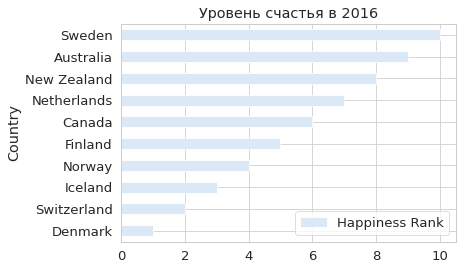

In [436]:
happiness_rank = happy_df.copy()[['Country', 'Happiness Rank']].set_index(happy_df['Country'])
happiness_rank.nsmallest(10, 'Happiness Rank').plot(kind='barh', title='Уровень счастья в 2016')

df_2016 = df[df['year'] == 2016]
df_2016_dict = df_2016['suicides_no'].groupby(df_2016['country']).sum().to_dict()
df_2016_sorted = df_2016['suicides_no'].groupby(df_2016['country']).sum().sort_values()

happy_dict = {}
for key in df_2016_dict:
    if key in happiness_rank['Country'].values:
        happy_dict[key] = happiness_rank.loc[key]
processed_happy_df = pd.DataFrame.from_dict(happy_dict, orient='index')

sorted_df_happiness = processed_happy_df.sort_index()

## Топ по странам по суммарному числу суицидов

Посмотрим, в какие годы и в какой стране было совершено больше суицидов.

In [437]:
# в конце восстанавливаем индекс, который поменялся при группировке:
# sui - сокращение для [РОСКОМНАДЗОР]
df_sui_per_country_and_year = pd.DataFrame(df.groupby(['country', 'year'])['suicides_no'].sum().reset_index())
print(df_sui_per_country_and_year.head())
print(df_sui_per_country_and_year.tail())

   country  year  suicides_no
0  Albania  1987         73.0
1  Albania  1988         63.0
2  Albania  1989         68.0
3  Albania  1992         47.0
4  Albania  1993         73.0
                   country  year  suicides_no
3000  Virgin Islands (USA)  2009          9.0
3001  Virgin Islands (USA)  2010          8.0
3002  Virgin Islands (USA)  2011          8.0
3003  Virgin Islands (USA)  2012         10.0
3004  Virgin Islands (USA)  2015          3.0


Изобразим на карте количество суицидов по обработанным данным:

In [438]:
df_sui_per_country = pd.DataFrame(
    df_sui_per_country_and_year.groupby('country')['suicides_no'].sum().reset_index())

world_map_count = [dict(
    type='choropleth',
    locations=df_sui_per_country['country'],
    locationmode='country names',
    z=df_sui_per_country['suicides_no'],
    text=df_sui_per_country['country'],
    colorscale='Viridis',
    autocolorscale=False,
    reversescale=True,
    marker=dict(line=dict(color='rgb(180,180,180)', width=0.5)),
    colorbar=dict(autotick=False, title='Количество суицидов в стране'),
)]
world_map_layout = dict(
    title='Количество суицидов за все время',
    geo=dict(
        showframe=True,
        showcoastlines=True,
        projection=dict(type='Mercator')
    )
)
world_map = dict(data=world_map_count, layout=world_map_layout)
iplot(world_map, validate=False, filename='d3-world-map')

Посортим получившиеся значения и изобразим на гистограмме:

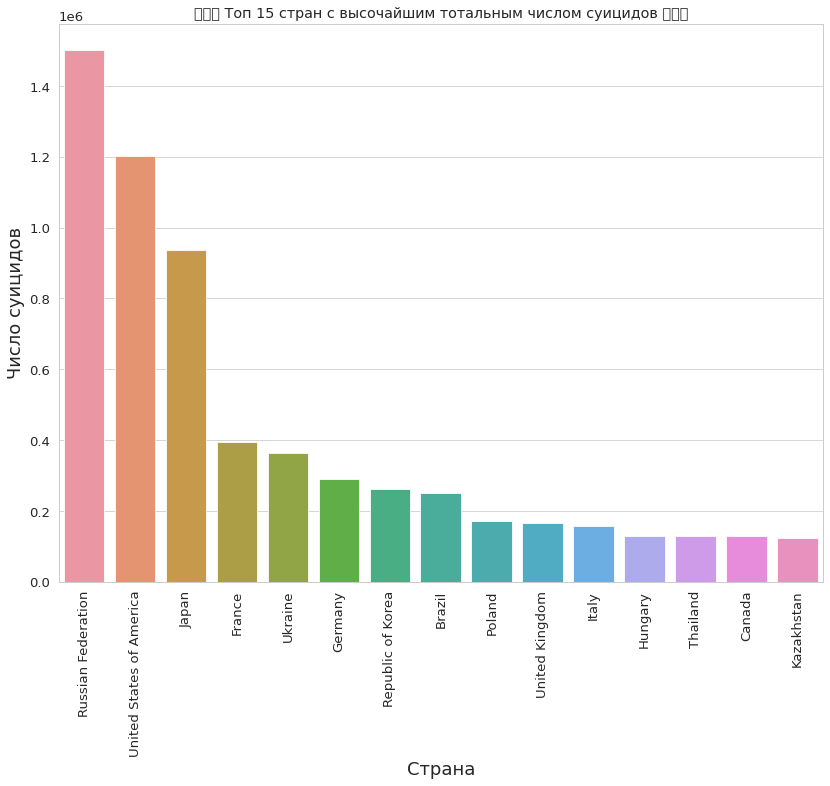

In [439]:
df_sui_per_country.sort_values(by=['suicides_no'], ascending=False, inplace=True)
world_map, _ = plt.subplots()
world_map.set_size_inches(13.7, 10.27)
f = seaborn.barplot(x=df_sui_per_country['country'].head(15), y=df_sui_per_country['suicides_no'].head(15),
                    data=df_sui_per_country)
f.set_xlabel('Страна', fontsize=18)
f.set_ylabel('Число суицидов', fontsize=18)
f.set_title('🇷🇺🇷 Топ 15 стран с высочайшим тотальным числом суицидов 🇷🇺🇷')
for item in f.get_xticklabels():  # лайфхак, чтобы читались лейблы
    item.set_rotation(90)

## Как себя убивали женщины и мужчины

Text(0, 0.5, 'Число суицидников')

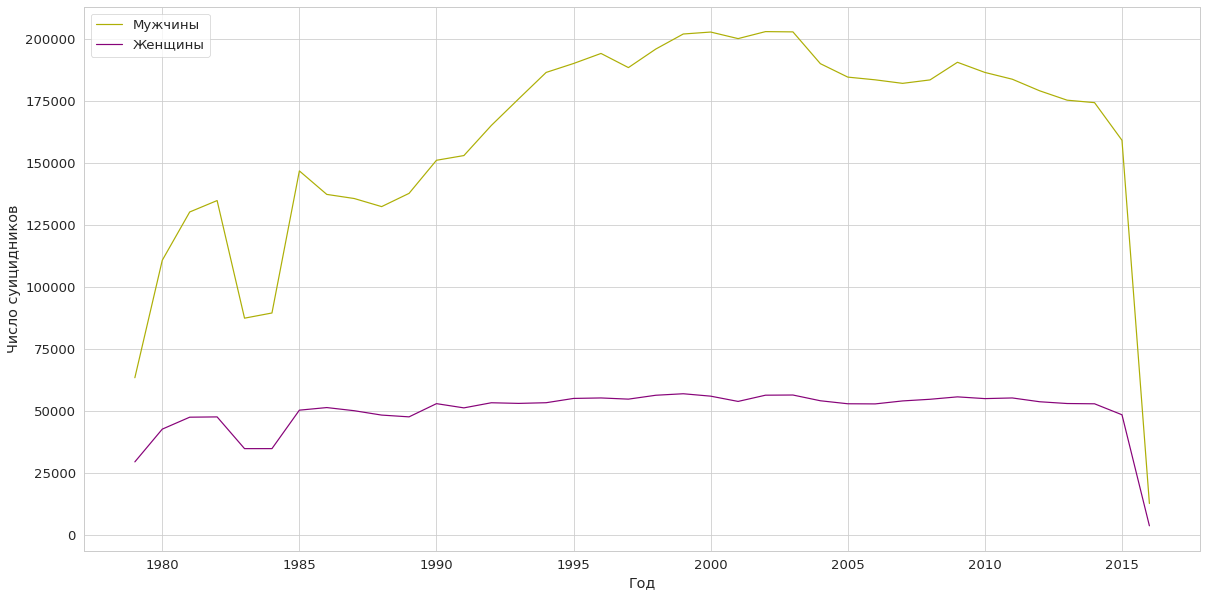

In [440]:
df_sui_mf = pd.DataFrame(df.groupby(['year', 'sex'])['suicides_no'].sum().reset_index())
df_sui_mf = df_sui_mf.round(0)
df_sui_mf.sort_values(by=['year'], inplace=True)
df_sui_m = df_sui_mf[df_sui_mf['sex'] == 'male']
df_sui_f = df_sui_mf[df_sui_mf['sex'] == 'female']

plt.figure(figsize=(20, 10))
plt.plot(df_sui_m.year, df_sui_m['suicides_no'], color='#ADAF06', label='Мужчины')
plt.plot(df_sui_f.year, df_sui_f['suicides_no'], color='#870379', label='Женщины')
plt.legend(loc="upper left")
plt.xlabel('Год')
plt.ylabel('Число суицидников')

# 1. Гипотеза №1

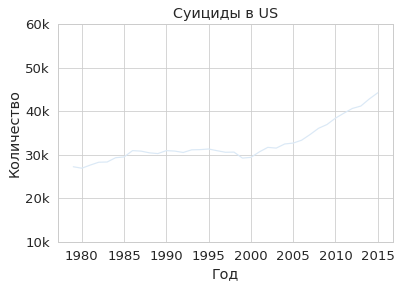

In [441]:
us = df[df['country'] == 'United States of America']
years = np.unique(us.year)

us_processed = np.transpose(pd.DataFrame([{i: us[us['year'] == i]['suicides_no'].values.sum() for i in years}]))
us_processed.columns = ['suicides']

plt.plot(us_processed)
plt.title('Суициды в US')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.yticks([10000, 20000, 30000, 40000, 50000, 60000], ['10k', '20k', '30k', '40k', '50k', '60k'])
plt.show()

Гипотеза №1: **год и число суицидов в США скоррелированы**.

Мотивация: звучит логично + видно из графиков.

Построим корреляционную матрицу:

In [442]:
us.corr()

,year,suicides_no,population,suicide_rate
year,1.000000,0.119406,0.261572,-0.058613
suicides_no,0.119406,1.000000,0.538416,0.595859
population,0.261572,0.538416,1.000000,-0.191970
suicide_rate,-0.058613,0.595859,-0.191970,1.000000


In [443]:
print(stats.pearsonr(us['year'], us['suicides_no']))

(0.11940635777677283, 0.011803338793630323)


Построим линейную регрессию:

In [444]:
us_values = us.values
us_year = us_values[:, 1]
us_x = np.unique(us_year).reshape(-1, 1)
us_y = us_processed.suicides.values

us_x_train, us_x_test, us_y_train, us_y_test = train_test_split(us_x, us_y, test_size=0.3, random_state=42)

In [445]:
us_reg = LinearRegression()
us_reg.fit(us_x_train, us_y_train)
us_y_pred = us_reg.predict(us_x_test)

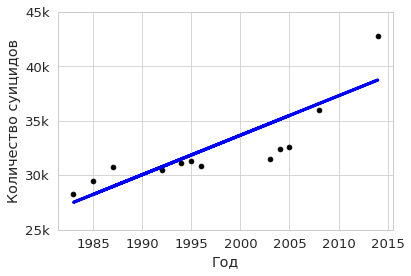

In [446]:
plt.scatter(us_x_test, us_y_test, color='black')
plt.plot(us_x_test, us_y_pred, color='blue', linewidth=3)
plt.xlabel('Год')
plt.ylabel('Количество суицидов')
plt.yticks([25000, 30000, 35000, 40000, 45000], ['25k', '30k', '35k', '40k', '45k'])
plt.show()

In [447]:
print(f'Коэффициенты:\t{us_reg.coef_}')
print(f'Оценка дисперсии:\t{r2_score(us_y_test, us_y_pred)}')  # (ближе к 1 = лучше)

Коэффициенты:	[362.98276643]
Оценка дисперсии:	0.6822574761539573


Проведем регрессию с полиномиальными фичами.

In [448]:
us_sui_per_year = pd.DataFrame(us.groupby('year')['suicides_no'].sum())  # не будем восстанавливать индекс
print(us_sui_per_year.head())
print(us_sui_per_year.tail())

      suicides_no
year             
1979      27189.0
1980      26852.0
1981      27574.0
1982      28226.0
1983      28280.0
      suicides_no
year             
2011      39508.0
2012      40596.0
2013      41143.0
2014      42769.0
2015      44189.0


In [449]:
us_x_2 = pd.DataFrame(us_sui_per_year.index)
us_y_2 = us_sui_per_year.iloc[:, 0]

# Убираем последний год, так как там неполная информация
us_x_2 = us_x_2.iloc[:-1, :].values.reshape(-1, 1)
us_y_2 = us_sui_per_year.iloc[:-1, 0].values.reshape(-1, 1)

Коэффициенты:	[[ 0.00000000e+00  3.52062222e+00  4.50186946e+03 -3.01151689e+00
   5.66591306e-04]]
Оценка дисперсии:	0.9662678898926672


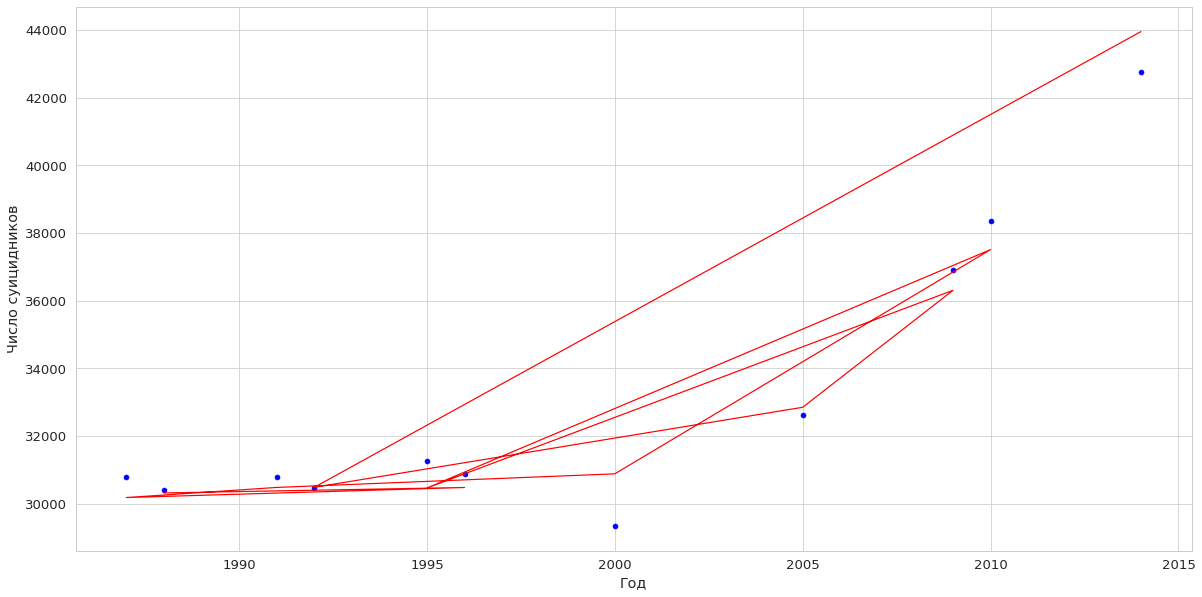

In [450]:
us_reg_2 = LinearRegression()
pf = PolynomialFeatures(degree=4)  # используем полиномы степени 4

us_x_train_2, us_x_test_2, us_y_train_2, us_y_test_2 = train_test_split(us_x_2, us_y_2, test_size=0.3, random_state=42)
us_x_train_transformed_2 = pf.fit_transform(us_x_train_2)
us_x_test_transformed_2 = pf.fit_transform(us_x_test_2)
us_reg_2.fit(us_x_train_transformed_2, us_y_train_2)
us_y_pred_2 = us_reg_2.predict(us_x_test_transformed_2)

plt.figure(figsize=(20, 10))
plt.scatter(us_x_test_2, us_y_test_2, color='blue')
plt.plot(us_x_test_2, us_y_pred_2, color='red')
plt.xlabel('Год')
plt.ylabel('Число суицидников')

print(f'Коэффициенты:\t{us_reg_2.coef_}')
print(f'Оценка дисперсии:\t{r2_score(us_y_test_2, us_y_pred_2)}')  # (ближе к 1 = лучше)

## Вывод
Гипотеза о коррелированности двух величин подтвердилась (коэффициент корреляции = 0.11940635777677283, он статистически значим, так как p ~ 1%). Переменные слабо коррелированы. Также для этих данных была построена неплохая линейная регрессия (оценка дисперсии 0.6822574761539573) и еще лучшая полиномиальная регрессия (0.9662678898926672).


# 2. Гипотеза №2

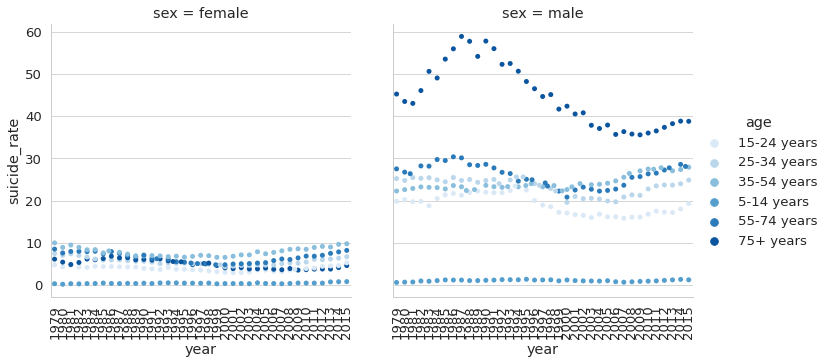

In [451]:
seaborn.catplot(x='year', y='suicide_rate', kind='swarm', hue='age', col='sex', data=us).set_xticklabels(rotation=90)

Гипотеза №2: **равномерная распределенность женских суицидов на долю населения в США по годам**.

Мотивация: такое впечатление складывается исходя из графиков.

In [452]:
stats.chisquare(us[us['sex'] == 'female'].groupby('year')['suicide_rate'].sum())

Power_divergenceResult(statistic=17.708488931917902, pvalue=0.9954708963953398)

## Вывод
Гипотеза с вероятностью ~0.5% верна (chi^2 = 17.708488931917902).

# 3. Гипотеза №3

In [453]:
ru = df[df['country'] == 'Russian Federation']
old_ru = ru[ru['age'] == '75+ years']

Гипотеза №3: **год и доля суицидников среди стариков в РФ скоррелированы**.

Мотивация: жалко стариков, хочется надеяться, что все меньше их выпиливаются из жизни.

In [454]:
print(stats.pearsonr(old_ru['year'], old_ru['suicide_rate']))
old_ru.corr()

(-0.2643023281116871, 0.029407879378028967)


,year,suicides_no,population,suicide_rate
year,1.000000,0.120477,0.311573,-0.264302
suicides_no,0.120477,1.000000,-0.018258,-0.007006
population,0.311573,-0.018258,1.000000,-0.969290
suicide_rate,-0.264302,-0.007006,-0.969290,1.000000


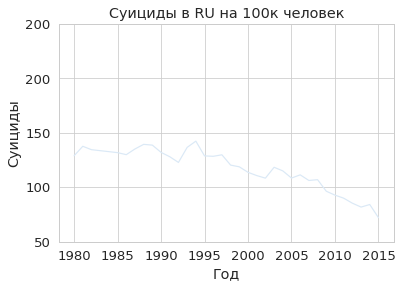

In [455]:
old_ru_years = np.unique(old_ru.year)

old_ru_processed = np.transpose(
    pd.DataFrame([{i: old_ru[old_ru['year'] == i]['suicide_rate'].values.sum() for i in old_ru_years}]))
old_ru_processed.columns = ['suicides']

plt.plot(old_ru_processed)
plt.title('Суициды в RU на 100к человек')
plt.xlabel('Год')
plt.ylabel('Суициды')
plt.yticks([50, 100, 150, 200, 250], ['50', '100', '150', '200', '200'])
plt.show()

In [456]:
old_ru_values = old_ru.values
old_ru_year = old_ru_values[:, 1]
old_ru_x = np.unique(old_ru_year).reshape(-1, 1)
old_ru_y = old_ru_processed.suicides.values

old_ru_x_train, old_ru_x_test, old_ru_y_train, old_ru_y_test = train_test_split(old_ru_x, old_ru_y, test_size=0.3,
                                                                                random_state=42)

In [457]:
old_ru_reg = LinearRegression()
old_ru_reg.fit(old_ru_x_train, old_ru_y_train)
old_ru_y_pred = old_ru_reg.predict(old_ru_x_test)

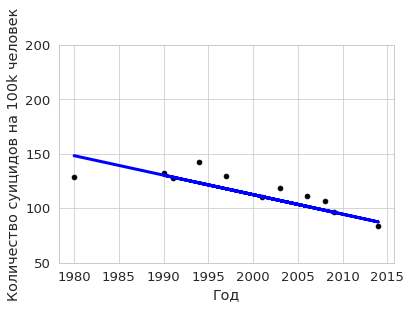

Коэффициенты:	[-1.79352273]
Оценка дисперсии:	0.5985437715326454


In [458]:
plt.scatter(old_ru_x_test, old_ru_y_test, color='black')
plt.plot(old_ru_x_test, old_ru_y_pred, color='blue', linewidth=3)
plt.xlabel('Год')
plt.ylabel('Количество суицидов на 100k человек')
plt.yticks([50, 100, 150, 200, 250], ['50', '100', '150', '200', '200'])
plt.show()

print(f'Коэффициенты:\t{old_ru_reg.coef_}')
print(f'Оценка дисперсии:\t{r2_score(old_ru_y_test, old_ru_y_pred)}')  # (ближе к 1 = лучше)

## Вывод
Гипотеза о коррелированности двух величин подтвердилась (коэффициент корреляции = -0.2643023281116871, он статистически значим, так как p ~ 3%). Переменные слабо коррелированы. Также для этих данных была построена неплохая линейная регрессия (оценка дисперсии 0.5985437715326454).

# 4. Гипотеза №4

Гипотеза №4: **количество молодых суицидников в этом году и количество девушек суицидников в этом году независимы**.

Мотивация: звучит естественно; хочется проверить, что я не ошибаюсь в своих изысканиях на какой-нибудь несложной гипотезе, типа такой.

In [459]:
by_year = df.groupby('year')
age_sex_crosstab = pd.crosstab(by_year.apply(lambda g: g[g['sex'] == 'female']['suicides_no'].sum()),
                               by_year.apply(lambda g: g[g['age'] == '15-24 years']['suicides_no'].sum()))
alpha = 0.05
stat, p, dof, _ = stats.chi2_contingency(age_sex_crosstab)
if p < alpha:
    print('Независимость не принимаем')
else:
    print('Величины независимы')
stat, p

Величины независимы


(1406.0000000000007, 0.23775345622288968)

## Вывод
Гипотеза проверяется на уровне значимости alpha = 0.05, chi^2 = 1406.0000000000007.

# 5. Гипотеза №5

<AxesSubplot:>

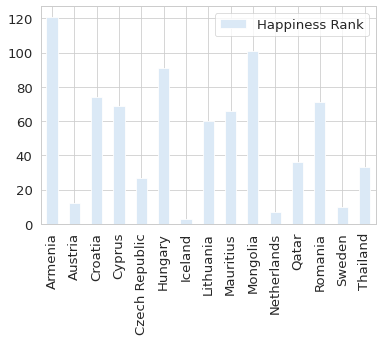

In [460]:
processed_happy_df.sort_index().plot(kind='bar')

Гипотеза №5: **уровень счастья и процент самоубийств независимы в стране**.

Мотивация: довольно смелая гипотеза, интересно было бы, если бы оно оказалось так!

<AxesSubplot:>

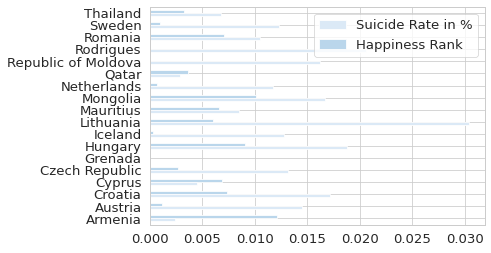

In [461]:
df_2016_pop = df_2016['population'].groupby(df_2016['country']).sum().sort_values()
df_2016_sui_proportion = (df_2016_sorted.sort_index() / df_2016_pop.sort_index()) * 100

result = pd.concat([df_2016_sui_proportion, sorted_df_happiness['Happiness Rank']], axis=1)
result.iloc[:, 1] = result['Happiness Rank'] / 10000
result = result.rename(columns={0: 'Suicide Rate in %'})
result.plot(kind='barh')

In [462]:
happiness_sui_proportion_crosstab = pd.crosstab(result['Happiness Rank'], df_2016_sui_proportion)
stat, p, dof, _ = stats.chi2_contingency(happiness_sui_proportion_crosstab)
if p < alpha:
    print('Независимость не принимаем')
else:
    print('Величины независимы')
stat, p

Величины независимы


(210.00000000000003, 0.23440290760272484)

## Вывод
Гипотеза проверяется на уровне значимости alpha = 0.05, chi^2 = 210.00000000000003.